### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import get_feature_extractor, extract_features, preprocessing_model
from utils.experiment_utils import get_images_from_supervised_set
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

In [11]:
models_dir = "c:/transformer_models/"
if os.path.isdir(models_dir) is not True:
    os.mkdir(models_dir)

### Load dataset

In [2]:
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

In [3]:
ds_name = 'caltech_birds2011'
birds_ds, birds_ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(birds_ds_info)

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='c:/datasets/caltech_birds2011\\0.1.1',
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': I

In [5]:
type(birds_ds[0])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [6]:
label_set = list(range(100,200))
train_images, train_labels = get_images_from_supervised_set(birds_ds[0], label_set,img_size=[224,224])
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (2994, 224, 224, 3)
labels shape = (2994,)


In [7]:
test_images, test_labels = get_images_from_supervised_set(birds_ds[1], label_set,img_size=[224,224])
print(f"images shape = {test_images.shape}")
print(f"labels shape = {test_labels.shape}")

images shape = (2930, 224, 224, 3)
labels shape = (2930,)


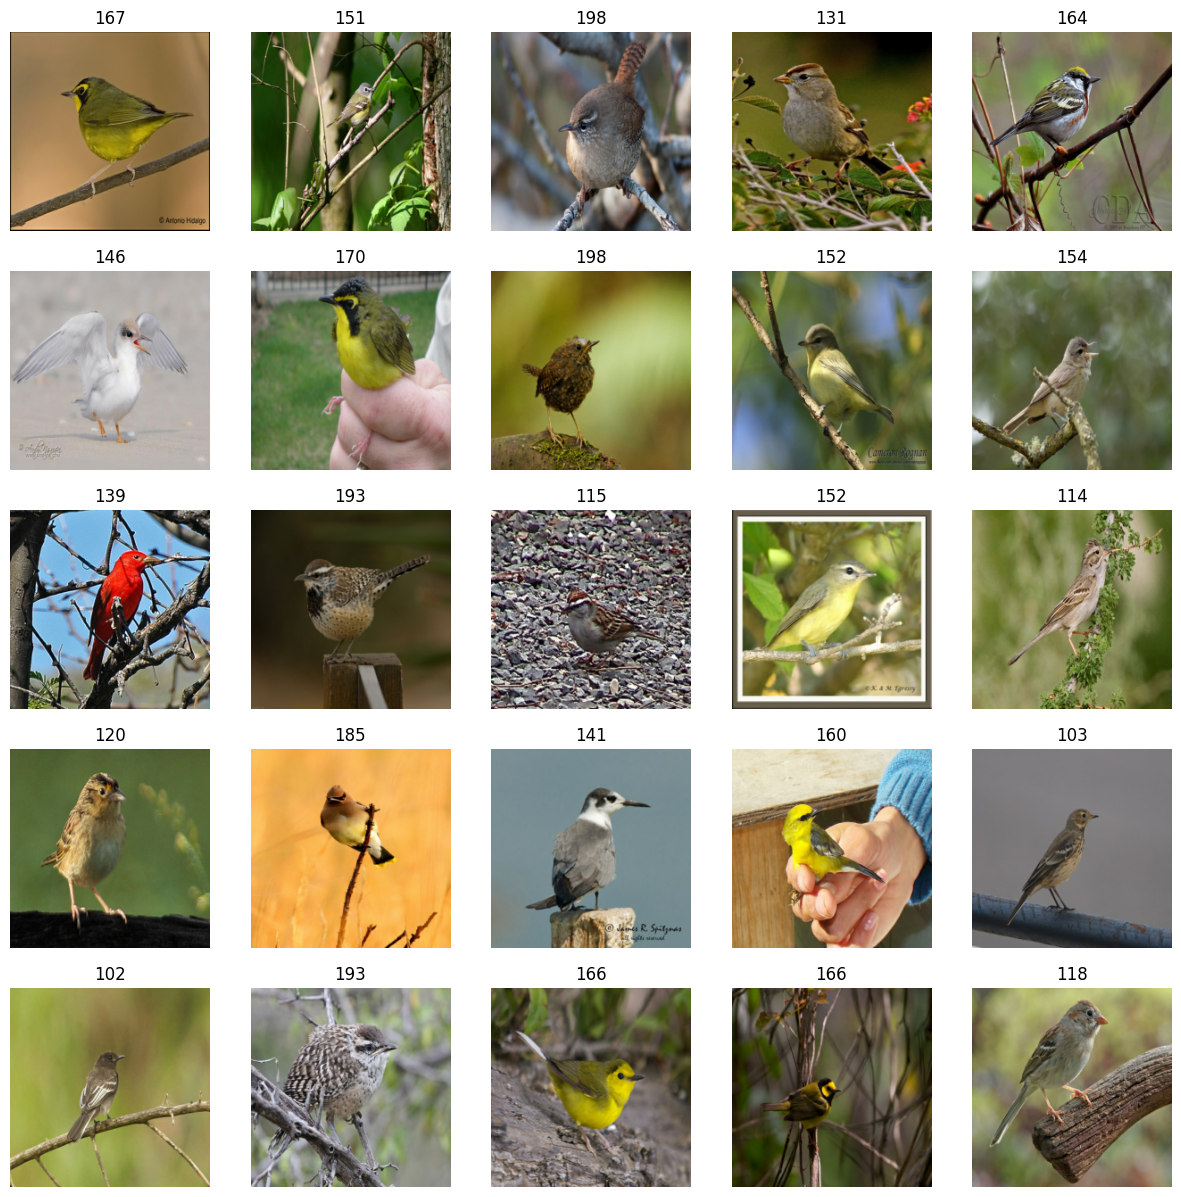

In [8]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    ax.set_title(f"{test_labels[i]}")
    plt.axis("off")

In [9]:
model_id = "google/vit-base-patch16-224-in21k"

In [16]:
from transformers import ViTFeatureExtractor
from tensorflow import keras
from tensorflow.keras import layers


vit_feature_extractor = ViTFeatureExtractor.from_pretrained(model_id, cache_dir=models_dir)

C:\python_venv\transfer_learning_with_feature_selection_python_3_10\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [18]:
a = vit_feature_extractor(train_images[0]/255.0)

In [25]:
(a['pixel_values'][0].shape)

(3, 224, 224)

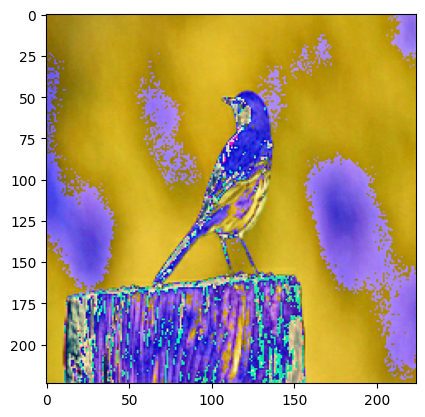

In [31]:
plt.imshow((a['pixel_values'][0].transpose((1, 2, 0))*255).astype("uint8")) #.astype("uint8")

In [32]:
import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', cache_dir=models_dir)
base_model.trainable = False
base_model.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86,389,248
Trainable params: 0
Non-trainable params: 86,389,248
_________________________________________________________________


In [35]:
vit = base_model.vit(np.expand_dims(a['pixel_values'][0], axis=0))

In [39]:
vit[0]

<tf.Tensor: shape=(1, 197, 768), dtype=float32, numpy=
array([[[ 0.09883793,  0.11224203,  0.07283764, ..., -0.06889769,
          0.18054684, -0.17743267],
        [ 0.02386244,  0.0369555 ,  0.03835712, ..., -0.1771347 ,
         -0.01178637, -0.05487007],
        [-0.00478038, -0.0404764 , -0.09222583, ..., -0.06173174,
         -0.09092189,  0.10325464],
        ...,
        [ 0.1670696 , -0.00439179,  0.0197104 , ...,  0.0067324 ,
         -0.05359836, -0.17623499],
        [ 0.05419537,  0.00651473, -0.00358956, ...,  0.11918432,
         -0.0349054 , -0.10100701],
        [ 0.09759265,  0.02601255,  0.18627663, ...,  0.11510362,
         -0.01642421, -0.17982736]]], dtype=float32)>

### Define a noise function

In [9]:
# create an additive noise
def add_noise(images, threshold, noise_delta, low_sat, high_sat):
    mask = np.random.rand(*images.numpy().shape[0:3])
    mask = mask < threshold
    mask = np.repeat(np.expand_dims(mask,axis=3), 3, axis=3)
    noise = np.random.randint(low=-noise_delta, high=noise_delta, size=images.shape) * mask
    return np.clip(images+noise, a_min=low_sat, a_max=high_sat)

In [10]:
def resize_down_up(images,size):
    orig_size = [images.shape[1],images.shape[2]]
    small_images = tf.image.resize(images, size=size, antialias=True)
    return tf.image.resize(small_images, size=orig_size, antialias=True)

In [11]:
#train_noisy_images = add_noise(images=train_images, threshold=0.6, noise_delta=80, low_sat=0, high_sat=255)
#test_noisy_images  = add_noise(images=test_images,  threshold=0.6, noise_delta=80, low_sat=0, high_sat=255)
train_noisy_images = resize_down_up(images=train_images, size=[64,64])
test_noisy_images  = resize_down_up(images=test_images,  size=[64,64])

In [12]:
fig, ax = plt.subplots(5,2,figsize=(6, 15))
for i in range(5):
    ax[i,1].imshow(train_noisy_images[i].numpy().astype("uint8"))
    ax[i,0].imshow(train_images[i].numpy().astype("uint8"))


### Define a feature extractor

In [15]:
model_name = 'MobileNetV2'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [24]:
model_name = 'InceptionV3'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.InceptionV3(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [36]:
model_name = 'EfficientNetV2B3'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.EfficientNetV2B3(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

52606240/52606240 [==============================] - 3s 0us/step
Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2

In [45]:
model_name = 'EfficientNetV2S'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.EfficientNetV2S(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

82420632/82420632 [==============================] - 4s 0us/step
Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                  

In [54]:
model_name = 'ConvNeXtTiny'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.ConvNeXtTiny(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

111650432/111650432 [==============================] - 5s 0us/step
Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 224, 224, 3)  0          ['input_14[0][0]']               
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 56, 56, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                 

In [53]:
train_images[0,:]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[208.13428 , 190.1294  , 138.95364 ],
        [208.29196 , 192.91153 , 136.47247 ],
        [209.1386  , 192.20859 , 139.55685 ],
        ...,
        [206.62572 , 189.2791  , 123.73244 ],
        [206.33731 , 189.35585 , 124.08542 ],
        [210.75235 , 192.0152  , 125.934204]],

       [[205.69868 , 190.71164 , 133.49742 ],
        [205.21344 , 187.8502  , 137.04886 ],
        [205.91687 , 189.0816  , 136.14119 ],
        ...,
        [204.66794 , 184.44946 , 121.87739 ],
        [202.03624 , 185.78436 , 118.43499 ],
        [206.32605 , 191.40126 , 117.369095]],

       [[205.64757 , 187.45784 , 133.35985 ],
        [203.69728 , 186.64471 , 136.03221 ],
        [205.04614 , 188.61551 , 137.38103 ],
        ...,
        [202.90804 , 181.23305 , 125.85241 ],
        [201.32071 , 184.7909  , 121.06597 ],
        [204.22995 , 188.76624 , 117.91364 ]],

       ...,

       [[226.24225 , 213.46165 , 140.17897 ],
        [225.

### Extract features

In [16]:
flatten_layer = tf.keras.layers.Flatten()

In [55]:
preprocess = preprocessing_model(input_shape=train_images.shape[1:],
                                            preprocess_layer=preprocess_input,
                                            noise_model=None)
feature_extractor = get_feature_extractor(base_model=base_model, input_shape=train_images.shape[1:], pooling_layer=global_average_layer)

In [56]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
X_test  = extract_features(ds=test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [57]:
X_train.shape

(2994, 768)

In [58]:
batch_size = 32
with tf.device('/cpu:0'):
    noisy_train_ds = tf.data.Dataset.from_tensor_slices(train_noisy_images).batch(batch_size)
    noisy_test_ds  = tf.data.Dataset.from_tensor_slices(test_noisy_images).batch(batch_size)
noisy_X_train = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
noisy_X_test  = extract_features(ds=noisy_test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [59]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
if tf.is_tensor(test_labels):
    y_test = test_labels.numpy()
else:
    y_test = test_labels
print(f"labels = {np.unique(y_train)}")


labels = [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]


### Experiment 1 - scanning train set size

In [64]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']), #
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
num_classes = 10
label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train, _, svm_y_train, _ = train_test_split(X_train[smpl_idx], y_train[smpl_idx], train_size=10*num_classes, stratify=y_train[smpl_idx])

# find hyper-parameters for the svm
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=100)
svm_best_params = hyper_opt.run()
# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=svm_X_train, y_train=svm_y_train, iterations=100)
lasso_best_params = hyper_opt.run()

100%|██████████| 100/100 [00:22<00:00,  4.37trial/s, best loss: -0.53]             


In [65]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 10

accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:-1,i,j], num_features[:-1,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                      X_train=smpl_X_train,
                                                                                      y_train=smpl_y_train,
                                                                                      X_test=exp_X_test,
                                                                                      y_test=exp_y_test)
        lasso_cls.fit(smpl_X_train, smpl_y_train)
        accuracies[-1,i,j] = lasso_cls.score(exp_X_test, exp_y_test)
        #print(lasso_cls.coef_.shape)
        lasso_features = []
        for v in range(lasso_cls.coef_.shape[0]):
            lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
        lasso_features = set(lasso_features)
        lasso_num_coeff = len(lasso_features)
        #print(f"lasso_num_coeff = {lasso_num_coeff}")
        num_features[-1,i,j] = lasso_num_coeff





        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:-1,i,j], num_features_w_noise[:-1,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                                      X_train=noisy_smpl_X_train,
                                                                                                      y_train=smpl_y_train,
                                                                                                      X_test=noisy_exp_X_test,
                                                                                                      y_test=exp_y_test)
        lasso_cls.fit(noisy_smpl_X_train, smpl_y_train)
        accuracies_w_noise[-1,i,j] = lasso_cls.score(noisy_exp_X_test, exp_y_test)
        #print(lasso_cls.coef_.shape)
        lasso_features = []
        for v in range(lasso_cls.coef_.shape[0]):
            lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
        lasso_features = set(lasso_features)
        lasso_num_coeff = len(lasso_features)
        #print(f"lasso_num_coeff = {lasso_num_coeff}")
        num_features_w_noise[-1,i,j] = lasso_num_coeff
    print("clean data")
    print("*******************")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.round(np.mean(accuracies[l,i,:]),2)}, std error is {np.round(np.std(accuracies[l,i,:])/np.sqrt(accuracies.shape[2]),2)}")
    print("\n\n")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.round(np.mean(num_features[l,i,:]),0)}, std error is {np.round(np.std(num_features[l,i,:])/np.sqrt(num_features.shape[2]),0)}")
    print("\n\n")
    print("noisy data")
    print("*******************")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.round(np.mean(accuracies_w_noise[l,i,:]),2)}, std error is {np.round(np.std(accuracies_w_noise[l,i,:])/np.sqrt(accuracies_w_noise.shape[2]),2)}")
    print("\n\n")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.round(np.mean(num_features_w_noise[l,i,:]),0)}, std error is {np.round(np.std(num_features_w_noise[l,i,:])/np.sqrt(num_features_w_noise.shape[2]),0)}")
    print("\n\n\n")

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
clean data
*******************
classifier cs_cls, mean accuracy is 0.68, std error is 0.02
classifier cs_fs_dp, mean accuracy is 0.66, std error is 0.02
classifier cs_fs_ova, mean accuracy is 0.68, std error is 0.02
classifier svm, mean accuracy is 0.68, std error is 0.01
classifier lasso, mean accuracy is 0.59, std error is 0.02



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num features is 163.0, std error is 9.0
classifier cs_fs_ova, mean num features is 678.0, std error is 5.0
classifier svm, mean num features is 768.0, std error is 0.0
classifier lasso, mean num features is 51.0, std error is 2.0



noisy data
*******************
classifier cs_cls, mean accuracy is 0.3, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.27, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.3, std error is 0.

#### Display accuracies

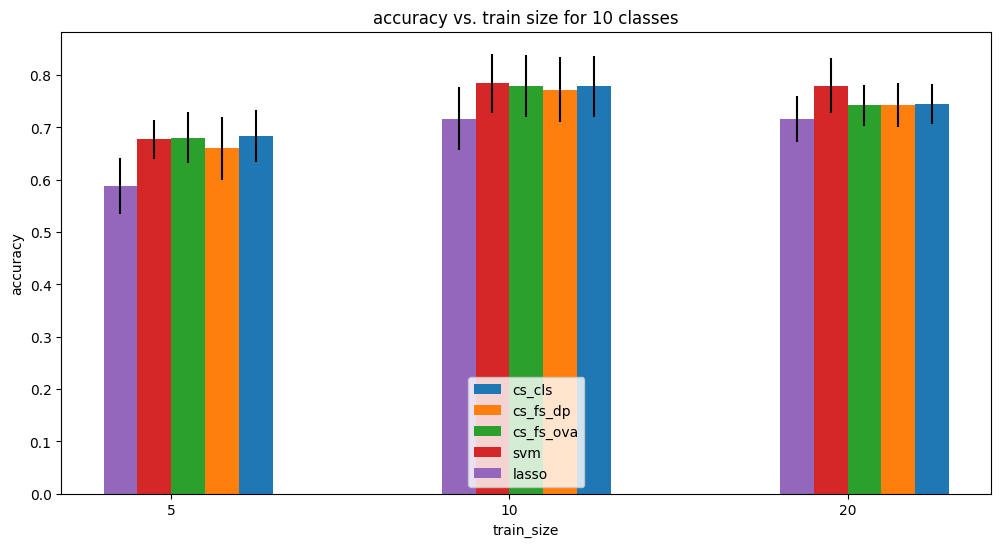

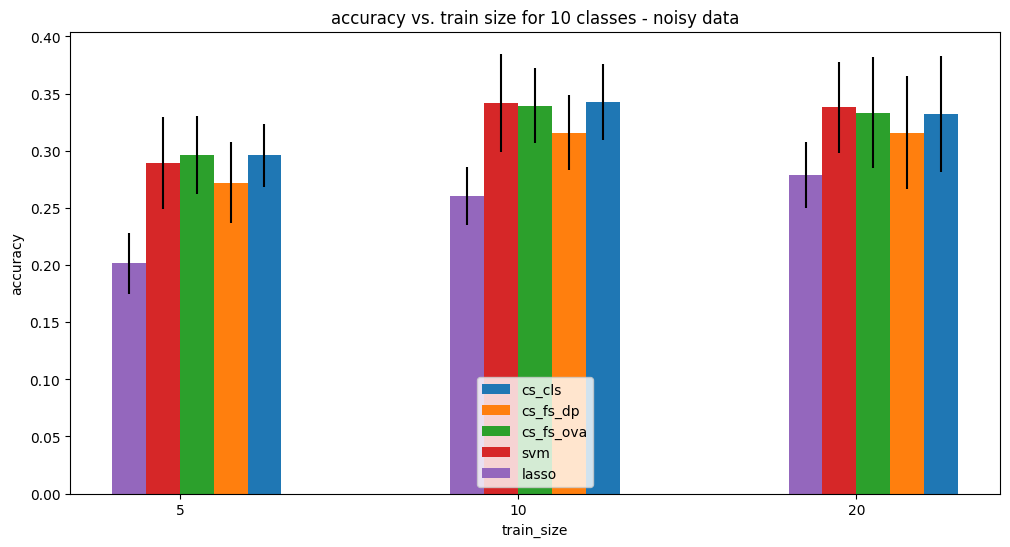

In [66]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes',
                err=np.std(accuracies,axis=2))
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data',
                err=np.std(accuracies_w_noise,axis=2))

#### Display numbers of selected features

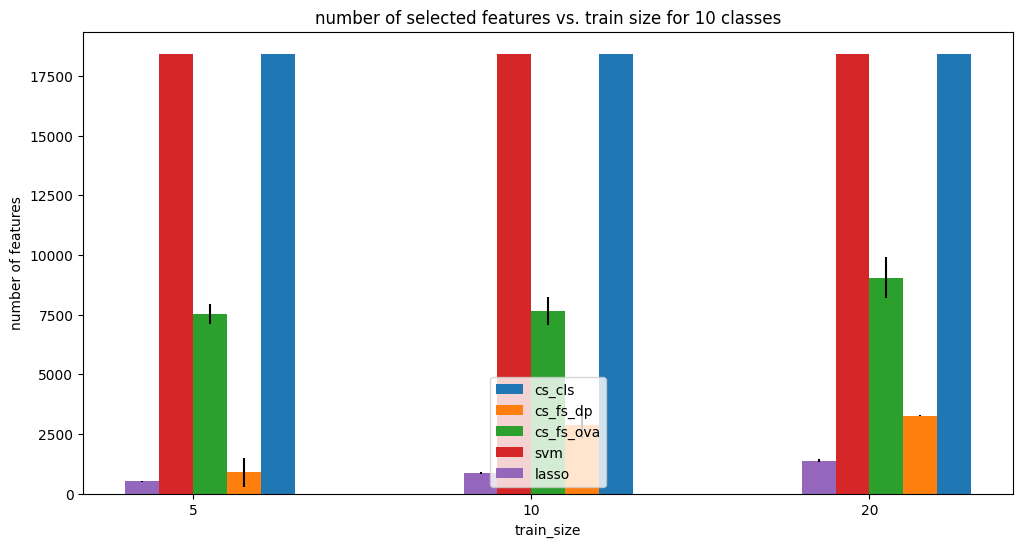

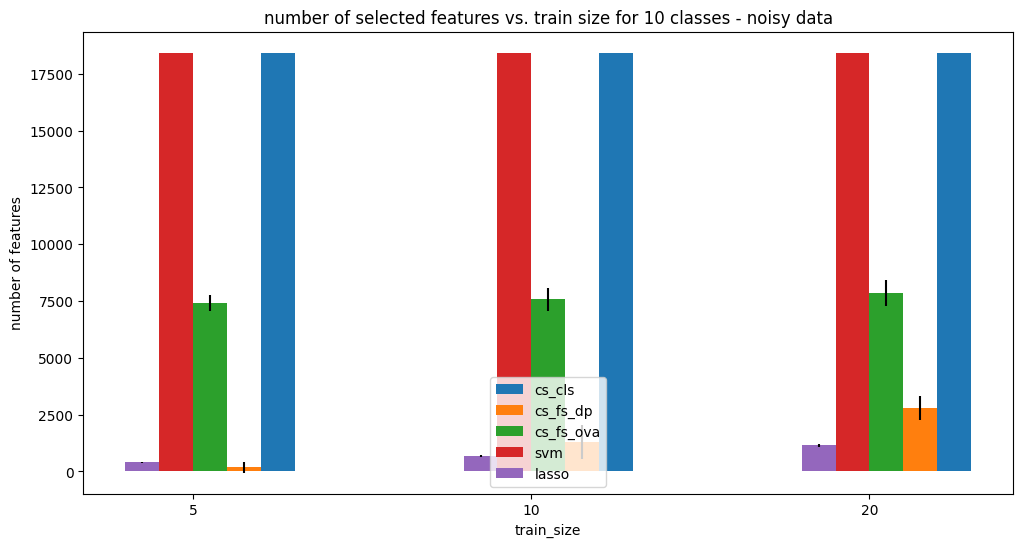

In [40]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=np.std(num_features,axis=2))
bar_plot_scores(scores=np.mean(num_features_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - noisy data',
                err=np.std(num_features_w_noise,axis=2))

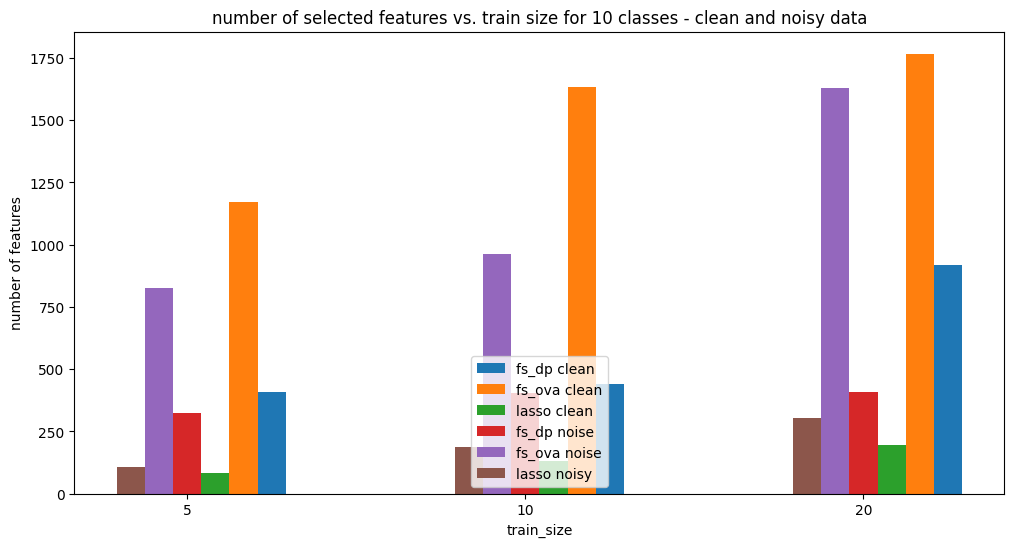

In [22]:
# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2,4],:,:], num_features_w_noise[[1,2,4],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'lasso clean', 'fs_dp noise', 'fs_ova noise', 'lasso noisy'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - clean and noisy data')

### Experiment 2 - scan the number of classes

Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 20 classes,  10 training examples per class
---------------------------------------------------------------






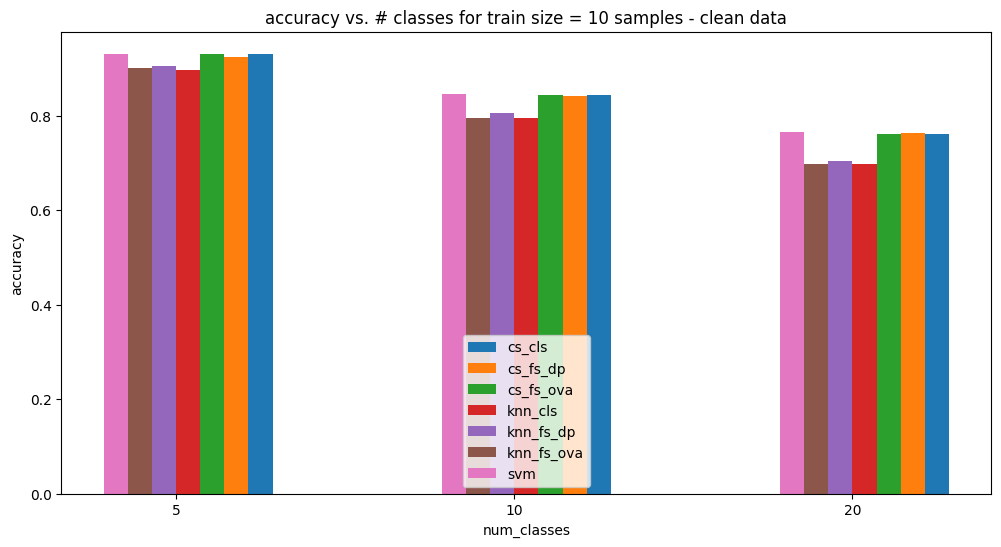

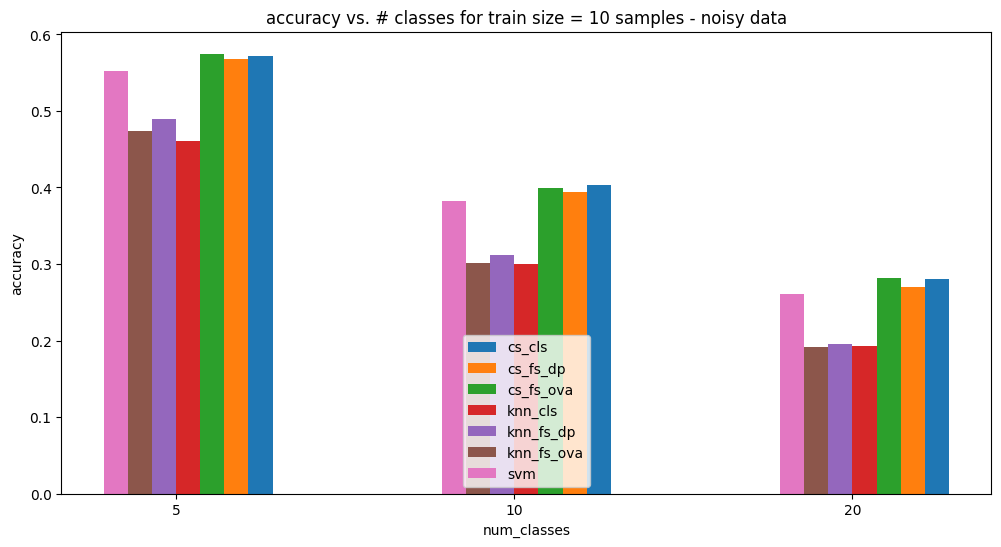

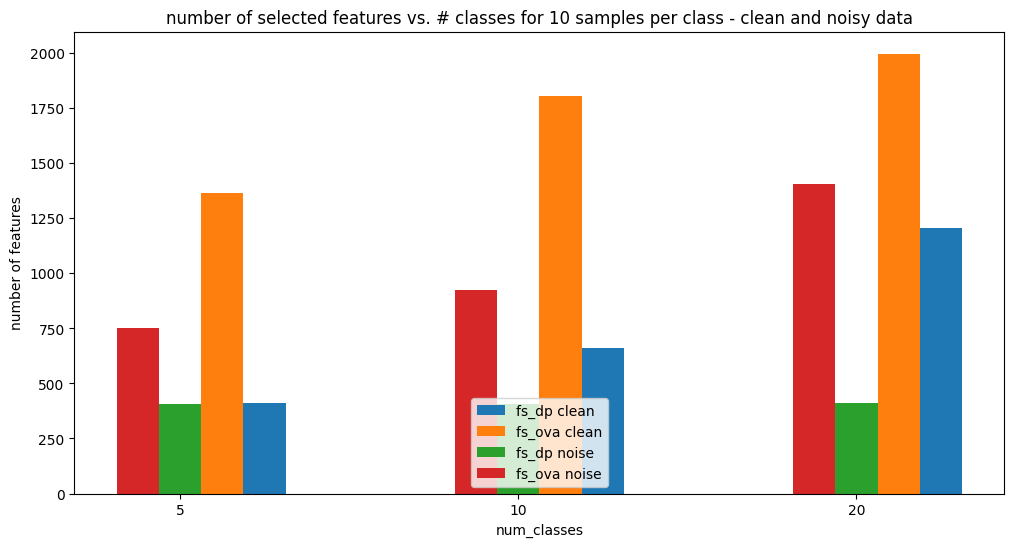

In [44]:
gamma = 0.2
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitKruskal(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
train_size = 10
num_classes = [5,10,20]
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(num_classes)):
    n = train_size
    print(f"Measuring accuracy with {num_classes[i]} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes[i],replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='accuracy',
                title=f'accuracy vs. # classes for train size = {train_size} samples - clean data')

# and the noisy data
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='accuracy',
                title=f'accuracy vs. # classes for train size = {train_size} samples - noisy data')

# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='number of features',
                title=f'number of selected features vs. # classes for {train_size} samples per class - clean and noisy data')

### Experiment 3 - Scan noise levels

In [33]:
use_additive_noise = False
# define noise profiles
if use_additive_noise:
    noise_profiles = {'th'  : [1 , 1 , 1 , 1  , 1  , 1],
                  'var' : [50, 70, 90, 110, 130, 150]}
    xticklabels = [f'th = {noise_profiles["th"][i]}, var = {noise_profiles["var"][i]}' for i in range(len(noise_profiles['th']))]
    num_noise_profiles = len(noise_profiles["th"])
else:
    noise_profiles = {'size' : [128,64,32,24,16]}
    xticklabels = [f'small image size= {noise_profiles["size"][i]}' for i in range(len(noise_profiles['size']))]
    num_noise_profiles = len(noise_profiles["size"])


Measuring accuracy with noise profile small image size= 128
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 64
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 32
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 24
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 16
---------------------------------------------------------------
addi

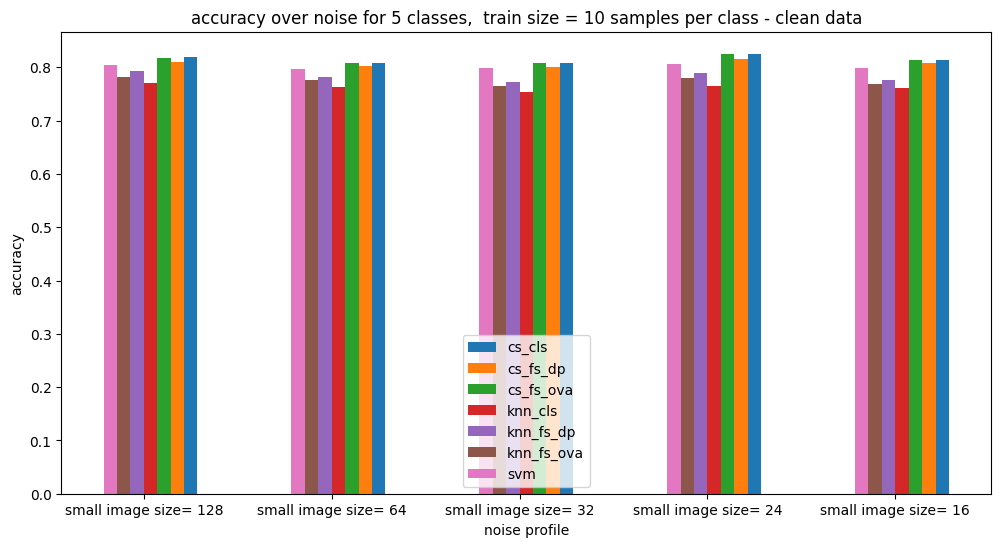

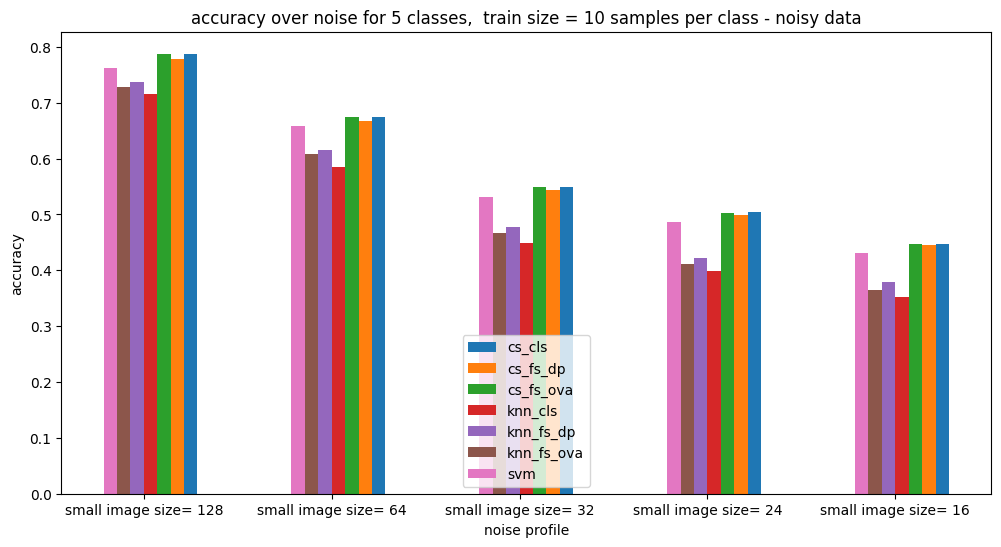

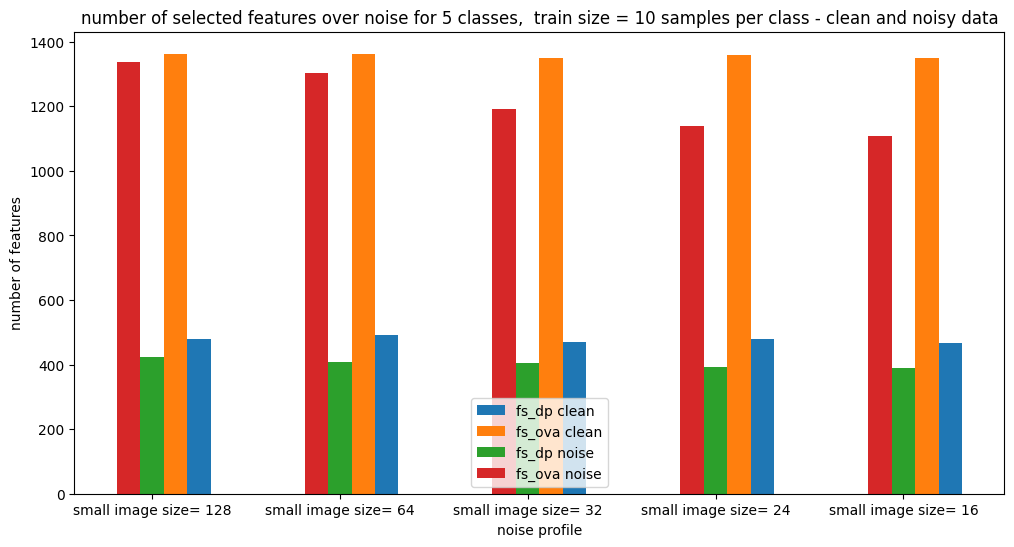

In [35]:
gamma = 0.2
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 100
# define possible sizes for the train set (number of train examples per class)
train_size  = 10
num_classes = 5
accuracies = np.empty((len(classifiers),num_noise_profiles,num_experiments))
accuracies_w_noise = np.empty_like(accuracies)
num_features = np.empty_like(accuracies)
num_features_w_noise = np.empty_like(accuracies)

for i in range(num_noise_profiles):

    print(f"Measuring accuracy with noise profile {xticklabels[i]}")
    print("---------------------------------------------------------------")
    print("adding noise to images...")
    if use_additive_noise:
        train_noisy_images = add_noise(images=train_images, threshold=noise_profiles['th'][i], noise_delta=noise_profiles['var'][i], low_sat=0, high_sat=255)
        test_noisy_images  = add_noise(images=test_images,  threshold=noise_profiles['th'][i], noise_delta=noise_profiles['var'][i], low_sat=0, high_sat=255)
    else:
        train_noisy_images = resize_down_up(images=train_images, size=[noise_profiles['size'][i],noise_profiles['size'][i]])
        test_noisy_images  = resize_down_up(images=test_images,  size=[noise_profiles['size'][i],noise_profiles['size'][i]])
    print("extracting features from noisy images...")
    batch_size = 32
    with tf.device('/cpu:0'):
        noisy_train_ds = tf.data.Dataset.from_tensor_slices(train_noisy_images).batch(batch_size)
        noisy_test_ds  = tf.data.Dataset.from_tensor_slices(test_noisy_images).batch(batch_size)
    noisy_X_train = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
    noisy_X_test  = extract_features(ds=noisy_test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
    print("running experiments....")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,train_size,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='accuracy',
                title=f'accuracy over noise for {num_classes} classes,  train size = {train_size} samples per class - clean data')

# and the noisy data
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='accuracy',
                title=f'accuracy over noise for {num_classes} classes,  train size = {train_size} samples per class - noisy data')

# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='number of features',
                title=f'number of selected features over noise for {num_classes} classes,  train size = {train_size} samples per class - clean and noisy data')

### Experiment 4 - classification on "hard to classify" labels

In [67]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X_train, y_train=y_train)
best_params = hyper_opt.run()
ref_model = SVC(**best_params)
ref_model.fit(X_train, y_train)
ref_model_pred = ref_model.predict(X_test)
ref_model_acc = accuracy_score(y_test, ref_model_pred)

  1%|▏         | 2/150 [00:17<21:27,  8.70s/trial, best loss: -0.5016605155750107] 


KeyboardInterrupt: 

In [38]:
class_report_dict = classification_report(y_test, ref_model_pred, output_dict=True)
threshold = 0.35
low_recall_classes = [c for c in list(np.unique(y_test)) if class_report_dict[str(c)]['recall'] < threshold]
print(low_recall_classes)

[8, 25, 26, 28, 29, 42, 58, 96]


In [69]:
low_recall_classes = [8, 25, 26, 28, 29, 42, 58, 96]


In [71]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 5
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=low_recall_classes,size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data')

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - noisy data')

Measuring accuracy with 5 classes,  5 training examples per class
---------------------------------------------------------------


ValueError: 'a' cannot be empty unless no samples are taken

### Experiment 5 - add noise to the features
In this experiment we extract features from the clean (high-res without added noise) images and then add Gaussian noise to the extracted features. The results show classification accuracy of the clean and noisy features.

In [25]:
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=5,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]

# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=100)
svm_best_params = hyper_opt.run()

# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=svm_X_train, y_train=svm_y_train, iterations=100)
lasso_best_params = hyper_opt.run()

100%|██████████| 100/100 [00:12<00:00,  8.02trial/s, best loss: -0.6333333333333334]


Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
clean data:
classifier cs_cls, mean accuracy is 0.7372933880975974, std accuracy is 0.06985330879771173
classifier cs_fs_dp, mean accuracy is 0.7215956148318157, std accuracy is 0.06750134411944533
classifier cs_fs_ova, mean accuracy is 0.7292459437725705, std accuracy is 0.06942060777727317
classifier svm, mean accuracy is 0.7468170504526396, std accuracy is 0.07301599499947735
classifier lasso, mean accuracy is 0.6193134631202393, std accuracy is 0.0799728435384282



noisy data:
classifier cs_cls, mean accuracy is 0.19298915645707454, std accuracy is 0.029302095779088426
classifier cs_fs_dp, mean accuracy is 0.17587508350492548, std accuracy is 0.041842207357135015
classifier cs_fs_ova, mean accuracy is 0.18044208212995447, std accuracy is 0.030844307402280648
classifier svm, mean accuracy is 0.1878169099119689, std accuracy is 0.02746585650526493
classi

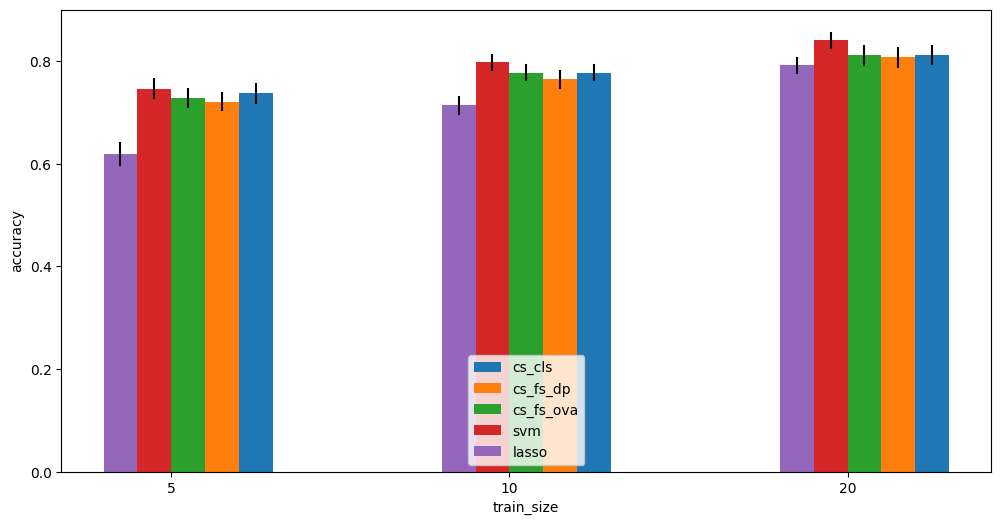

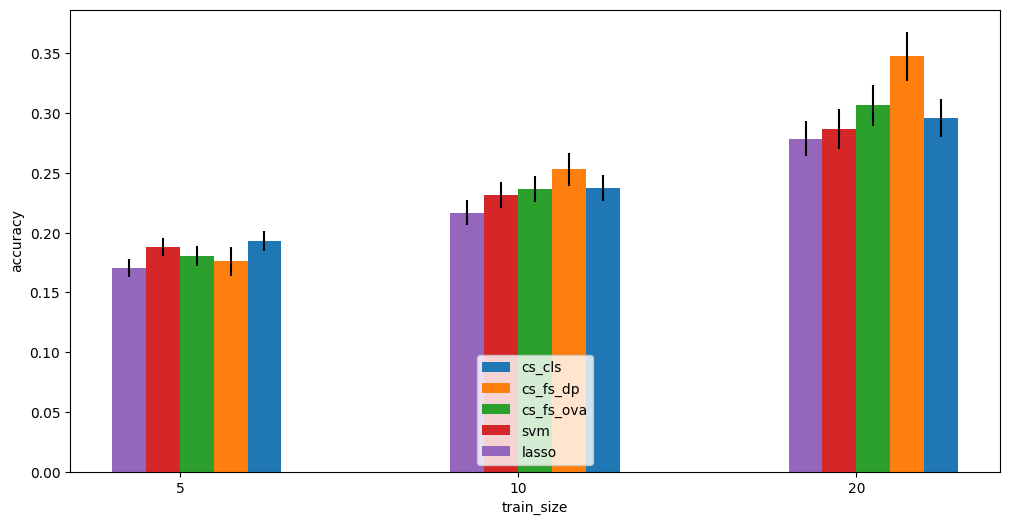

In [46]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
from utils.visualization import bar_plot_scores
gamma = 0.2
train_sizes = [5,10,20]
noise_std = 4
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:-1,i,j], num_features[:-1,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1], X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)
        lasso_cls.fit(smpl_X_train, smpl_y_train)
        accuracies[-1,i,j] = lasso_cls.score(exp_X_test, exp_y_test)
        lasso_features = []
        for v in range(lasso_cls.coef_.shape[0]):
            lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
        lasso_features = set(lasso_features)
        lasso_num_coeff = len(lasso_features)
        num_features[-1,i,j] = lasso_num_coeff




        noisy_smpl_X_train = smpl_X_train + np.random.randn(*smpl_X_train.shape)*noise_std
        noisy_exp_X_test = exp_X_test + np.random.randn(*exp_X_test.shape)*noise_std

        accuracies_w_noise[:-1,i,j], num_features_w_noise[:-1,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                                      X_train=noisy_smpl_X_train,
                                                                                                      y_train=smpl_y_train,
                                                                                                      X_test=noisy_exp_X_test,
                                                                                                      y_test=exp_y_test)
        lasso_cls.fit(noisy_smpl_X_train, smpl_y_train)
        accuracies_w_noise[-1,i,j] = lasso_cls.score(noisy_exp_X_test, exp_y_test)
        lasso_features = []
        for v in range(lasso_cls.coef_.shape[0]):
            lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
        lasso_features = set(lasso_features)
        lasso_num_coeff = len(lasso_features)
        num_features_w_noise[-1,i,j] = lasso_num_coeff


    print("clean data:")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    print("\n\n")
    print("noisy data:")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies_w_noise[l,i,:])}, std accuracy is {np.std(accuracies_w_noise[l,i,:])}")
    print("\n\n\n")



# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'',
                err=2*np.std(accuracies,axis=2)/np.sqrt(accuracies.shape[2]))


# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'',
                err=2*np.std(accuracies_w_noise,axis=2)/np.sqrt(accuracies_w_noise.shape[2]))




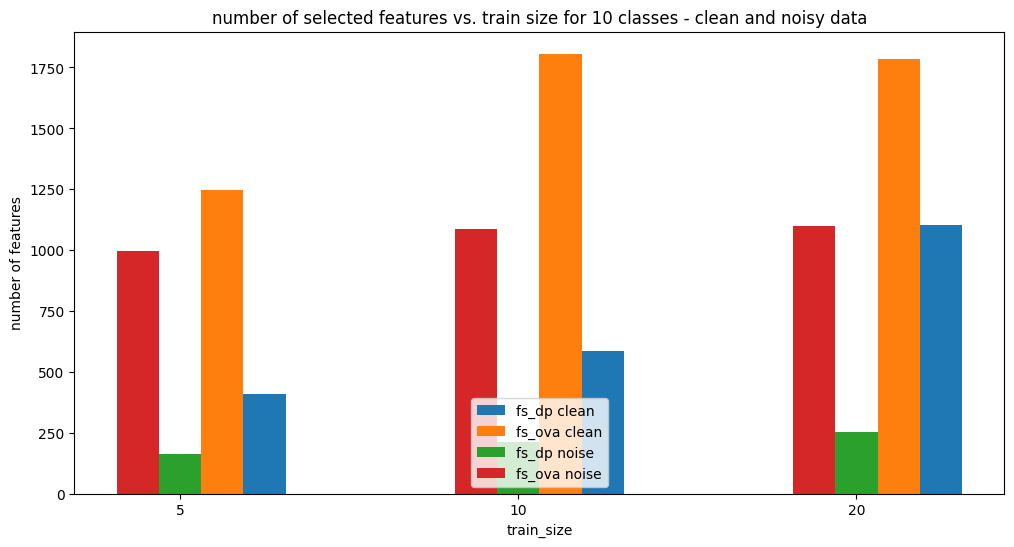

In [17]:
# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - clean and noisy data',
                err=2*np.std(accuracies_w_noise,axis=2)/np.sqrt(accuracies_w_noise.shape[2]))